#### Load Dependencies

In [ ]:
# pip install codecarbon

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup, AutoTokenizer, AutoModelForMaskedLM
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

#from codecarbon import EmissionsTracker


In [ ]:
# current_directory = Path.cwd()
# base_directory = current_directory.parent
# results_file_sample = base_directory/'data'/'...'

#### Load And Inspect Data

In [ ]:
data_path = '/content/fixed_examples_v03.csv'
data = pd.read_csv(data_path, delimiter="/")
data.head()

,skills,context,buzzwords,action_verbs,verb_tense,target
0,JavaScript,I have developed interactive front-end applica...,interactive; front-end; applications,developed,past,1.0
1,Data Visualization,Data Visualization is a skill I plan to learn...,learn,learn,present,0.0
2,React,My recent projects involved creating dynamic ...,dynamic; web pages; projects,creating,past,1.0
3,Machine Learning,I’m currently undertaking a course to underst...,fundamentals; course,undertaking,present,0.0
4,SQL,"In my previous role, I was responsible for da...",database management; previous role; responsible,was responsible,past,1.0


In [ ]:
# Convert the target column to integer if it's not already
if data['target'].dtype != 'int64':
    try:
        data['target'] = data['target'].astype(int)
        print("Target column converted to integer.")
    except ValueError:
        print("Conversion to integer failed. Check if all values in the target column are numeric.")
else:
    print('Target values are in correct format')

Target column converted to integer.


#### Assign Variables

In [ ]:
# Pre-trained model and tokenizer
pretrained_model_name = 'bert-base-uncased'
pretrained_tokenizer_name = "bert-base-uncased"

In [ ]:
features_for_fine_tuning = data['context'] # F1, F2 variable, E.G. data['context', 'skill']
target_for_fine_tuning = data['target'] # Y variable

In [ ]:
# Hyperparameters and other important variables
# batch_sizes = [8]
batch_sizes = [8, 16, 24, 32, 64]
epochs = 10

In [ ]:
# Name of fine-tuned model to be exported
fine_tuned_model_name = 'screen_bert_2fc_v0_1'
tokenizer_directory_name = 'tokenizer_directory'

In [ ]:
# Set random seed for reproducibility
seed_value = 42
torch.manual_seed(seed_value)
np.random.seed(seed_value)

#### Check Data

Number of values for 'Not Skilled' (0): 299
Number of values for 'Skilled' (1): 301
 


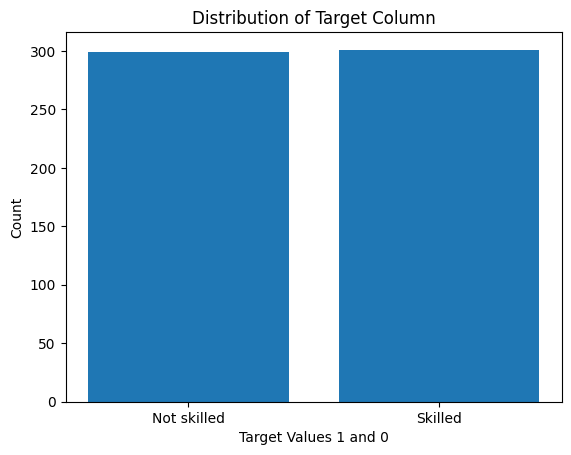

In [ ]:
# Plot and check whether data is balanced
target_counts = data['target'].value_counts()
print("Number of values for 'Not Skilled' (0):", target_counts[0])
print("Number of values for 'Skilled' (1):", target_counts[1])
print(' ')

plt.bar(target_counts.index, target_counts.values)
plt.xlabel('Target Values 1 and 0')
plt.ylabel('Count')
plt.title('Distribution of Target Column')
plt.xticks(target_counts.index, ['Skilled','Not skilled'])
plt.show()

#### Helper Functions For Training, Evaluation, Plotting

In [ ]:
def create_dataloader(encodings, labels, batch_size, randomize=True):
    """Create DataLoader for data with given batch size."""
    dataset = TensorDataset(torch.tensor(encodings['input_ids']),
                            torch.tensor(encodings['attention_mask']),
                            labels)

    if randomize:
        sampler = RandomSampler(dataset)
    else:
        sampler = None

    return DataLoader(dataset, sampler=sampler, batch_size=batch_size)

##### K-fold to be continued

In [ ]:
# to be updated
from sklearn.model_selection import StratifiedKFold
def k_fold_train_validate(texts, labels,
                    # val_dataset
                    pretrained_tokenizer,
                    model, optimizer, device, epochs, batch_size,
                    n_splits=5):

    print(type(labels.to_list()[0]))


    # Define cross-validation strategy
    kf = StratifiedKFold(n_splits=n_splits,
                        shuffle=True,
                        random_state=42)
    print("Strategy is set")

    train_loss_per_fold = []
    accuracy_per_fold = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(kf.split(texts, labels)):
        print('fold', fold)
        print('train_index', train_index)
        print('val_index', val_index)

        train_texts = [texts.to_list()[i] for i in train_index]
        train_labels = [labels.to_list()[i] for i in train_index]
        val_texts = [texts.to_list()[i] for i in val_index]
        val_labels = [labels.to_list()[i] for i in val_index]

        print('split completed')

        print(type(train_labels[0]), type(val_labels[0]))
        train_labels = torch.tensor(train_labels)
        val_labels = torch.tensor(val_labels)
        print(type(train_labels), type(val_labels))

        train_encodings = pretrained_tokenizer(train_texts, truncation=True, padding=True)
        print("train_encodings done")
        val_encodings = pretrained_tokenizer(val_texts, truncation=True, padding=True)
        print("val_encodings done")

        train_dataloader = create_dataloader(train_encodings,
                                             train_labels,
                                             batch_size=batch_size,
                                             )
        print("train_dataloader ready to play")

        val_dataloader = create_dataloader(val_encodings,
                                           val_labels,
                                           batch_size=batch_size)
        print("val_dataloader ready to play")

        avg_train_loss = train_model(model, train_dataloader, optimizer, device, epochs, batch_size)
        accuracy = evaluate_model(model, val_dataloader, device)

        train_loss_per_fold.append(avg_train_loss)
        accuracy_per_fold.append(accuracy)

    return train_loss_per_fold, accuracy_per_fold

#### Defining Model Class

In [ ]:
# Define a classification model on top of pre-trained model
class ScreenBert(nn.Module):
    def __init__(self, pretrained_model_name, dropout_prob=0.1):
        super(ScreenBert, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_name)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(768, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output)
        pooled_output = nn.ReLU()(self.fc1(pooled_output))
        logits = self.fc2(pooled_output)
        return logits

In [ ]:
def train_model(optimizer, epochs, model, dataloader, device):
    """Training loop for the model."""

    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0,
                                                num_training_steps = epochs * dataloader.dataset.__len__()/ batch_size
                                                )
    # Set to training mode
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []

    for step, batch in enumerate(dataloader):

        # progress update after every 50 batches
        if step % 50 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(dataloader)))

        # push current dataloader batch to respective device
        batch = tuple(t.to(device) for t in batch)

        input_ids, attention_mask, labels = batch

        # clear optimizer gradients
        optimizer.zero_grad()

        # get model predictions for the current batch
        logits = model(input_ids, attention_mask)

        # # compute the loss between actual and predicted values
        # loss = nn.CrossEntropyLoss()(logits, labels)
        loss_function = nn.BCEWithLogitsLoss()
        loss = loss_function(logits.squeeze(), labels.float())

        # add on to the total loss
        total_loss += loss.item()

        # compute accuracy for the current batch
        batch_predictions = torch.sigmoid(logits).cpu()
        batch_predictions = batch_predictions.round().detach().numpy()
        predictions.extend(batch_predictions)

        # store true labels
        true_labels.extend(labels.cpu().numpy())

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0 to prevent exploding gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()
        scheduler.step()

    # compute training loss and accuracy of epoch
    avg_train_loss = total_loss / len(dataloader)
    total_train_accuracy = accuracy_score(true_labels, predictions)


    return avg_train_loss, total_train_accuracy

In [ ]:
def evaluate_model(model, dataloader, device):

    # Deactivate dropout layers
    model.eval()

    total_loss = 0
    predictions = []
    true_labels = []

    # Iterate over batches
    for step, batch in enumerate(dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Report progress.
            print('Batch {:>5,}  of  {:>5,}.'.format(step, len(dataloader)))

        # Push batch to device
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        # Deactivate autograd
        with torch.no_grad():
            # Model predictions
            logits = model(input_ids, attention_mask)
            # Compute the loss between actual and predicted values
            loss_function = nn.BCEWithLogitsLoss()
            loss = loss_function(logits.squeeze(), labels.float())
            # Add on to the total loss
            total_loss += loss.item()

            # # Compute accuracy for the current batch
            batch_predictions = torch.sigmoid(logits).cpu()
            batch_predictions = batch_predictions.round().numpy()
            predictions.extend(batch_predictions)

            # Store true labels
            true_labels.extend(labels.cpu().numpy())

    # Compute evaluation loss and accuracy
    avg_loss = total_loss / len(dataloader)
    total_accuracy = accuracy_score(true_labels, predictions)

    return avg_loss, total_accuracy


In [ ]:
def train_and_evaluate_model(train_encodings, val_encodings,
                             train_labels, val_labels,
                             batch_size, epochs, model, device,
                             ):


    train_dataloader = create_dataloader(train_encodings,
                                         train_labels,
                                         batch_size=batch_size,
                                         )
    print("train_dataloader ready to play")

    val_dataloader = create_dataloader(val_encodings,
                                       val_labels,
                                       batch_size=batch_size
                                       )
    print("val_dataloader ready to play")

    # empty lists to store training and validation loss of each epoch
    train_losses=[]
    valid_losses=[]
    train_acc=[]
    valid_acc=[]

    print("Start training ...")
    for epoch in range(epochs):
        avg_train_loss, avg_train_accuracy = train_model(optimizer,
                                                         epochs,
                                                         model,
                                                         train_dataloader,
                                                         device)
        avg_val_loss, avg_val_accuracy = evaluate_model(model, val_dataloader, device)

        print(f'Epoch {epoch}/{epochs}')
        print(f'Training Loss: {avg_train_loss:.3f}, Validation Loss: {avg_val_loss:.3f}')
        print(f'Training Accuracy: {avg_train_accuracy:.3f}, Validation Accuracy: {avg_val_accuracy:.3f}')

        # document losses and acc
        train_losses.append(avg_train_loss)
        valid_losses.append(avg_val_loss)
        train_acc.append(avg_train_accuracy)
        valid_acc.append(avg_val_accuracy)

    return train_losses, valid_losses, train_acc, valid_acc

In [ ]:
def train_and_evaluate_model_with_early_stopping(train_encodings, val_encodings,
                                                 train_labels, val_labels,
                                                 batch_size, epochs, model, device,
                                                 patience=2):  # Patience parameter for early stopping
    train_dataloader = create_dataloader(train_encodings, train_labels, batch_size=batch_size)
    val_dataloader = create_dataloader(val_encodings, val_labels, batch_size=batch_size)

    best_val_loss = float('inf')  # Initialize best validation loss
    best_model_state_dict = None
    patience_counter = patience  # Initialize patience counter

    for epoch in range(epochs):
        avg_train_loss, avg_train_accuracy = train_model(optimizer, epoch, model, train_dataloader, device)
        avg_val_loss, avg_val_accuracy = evaluate_model(model, val_dataloader, device)

        print(f'Epoch {epoch + 1}/{epochs}')
        print(f'Training Loss: {avg_train_loss:.3f}, Validation Loss: {avg_val_loss:.3f}')
        print(f'Training Accuracy: {avg_train_accuracy:.3f}, Validation Accuracy: {avg_val_accuracy:.3f}')

        # Check if validation loss has improved
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state_dict = model.state_dict()
            patience_counter = patience  # Reset patience counter
        else:
            patience_counter -= 1  # Decrement patience counter

        # Check for early stopping
        if patience_counter == 0:
            print("Early stopping: No improvement in validation loss for {} epochs".format(patience))
            break

    # Load best model state
    if best_model_state_dict is not None:
        model.load_state_dict(best_model_state_dict)

    return train_losses, valid_losses, train_acc, valid_acc


In [ ]:
##Graph each batch size
def plot_results(batch_size_data):
  # Define colors for each batch size
  colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

  # Plot losses for each batch size
  for idx, (batch_size, data) in enumerate(batch_size_data.items()):
      train_losses = data['train_losses']
      valid_losses = data['valid_losses']
      epochs = range(1, len(train_losses) + 1)
      color = colors[idx % len(colors)]  # Cycle through colors for each batch size

      plt.figure(figsize=(10, 5))
      plt.plot(epochs, train_losses, linestyle='--', color=color, label='Train Loss')
      plt.plot(epochs, valid_losses, linestyle='-', color=color, label='Validation Loss')
      plt.title(f'Training and Validation Loss (Batch Size: {batch_size})')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.legend()
      plt.show()

  # Plot accuracies for each batch size
  for idx, (batch_size, data) in enumerate(batch_size_data.items()):
      train_acc = data['train_acc']
      valid_acc = data['valid_acc']
      epochs = range(1, len(train_acc) + 1)
      color = colors[idx % len(colors)]  # Cycle through colors for each batch size

      plt.figure(figsize=(10, 5))
      plt.plot(epochs, train_acc, linestyle='--', color=color, label='Train Accuracy')
      plt.plot(epochs, valid_acc, linestyle='-', color=color, label='Validation Accuracy')
      plt.title(f'Training and Validation Accuracy (Batch Size: {batch_size})')
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.legend()
      plt.show()


#### Fine-Tuning Pre-Trained Model

In [ ]:
# Split data into train, test and validation sets
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    features_for_fine_tuning,
    target_for_fine_tuning,
    test_size=0.2,
    stratify = target_for_fine_tuning,
    random_state=42
)

test_texts, val_texts, test_labels, val_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,
    stratify = temp_labels,
    random_state=42
)

# Validate sizes and proportion of target
print(train_texts.shape, test_texts.shape, val_texts.shape)
print(train_labels.shape, test_labels.shape, val_labels.shape)
print('---')
print(train_labels.value_counts(normalize=True))
print(test_labels.value_counts(normalize=True))
print(val_labels.value_counts(normalize=True))

(480,) (60,) (60,)
(480,) (60,) (60,)
---
target
1    0.502083
0    0.497917
Name: proportion, dtype: float64
target
0    0.5
1    0.5
Name: proportion, dtype: float64
target
0    0.5
1    0.5
Name: proportion, dtype: float64


In [ ]:
# Load tokenizer
pretrained_tokenizer = BertTokenizer.from_pretrained(pretrained_tokenizer_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# Tokenize and encode text data
test_encodings = pretrained_tokenizer(test_texts.tolist(),
                                      truncation=True,
                                      padding=True)

train_encodings = pretrained_tokenizer(train_texts.tolist(),
                                       truncation=True,
                                       padding=True)

val_encodings = pretrained_tokenizer(val_texts.tolist(),
                                     truncation=True,
                                     padding=True)

print("Encodings done")

Encodings done


In [ ]:
# Convert Convert Integer Sequences from Labels to Tensors
train_labels = torch.tensor(train_labels.tolist())
test_labels = torch.tensor(test_labels.tolist())
val_labels = torch.tensor(val_labels.tolist())
print("Converting labels to tensors done")

Converting labels to tensors done


In [ ]:
# Prepare for model loading. If running on GPU, assign compute unified device architecture
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'GPU computation device: {device}')
else:
    device = 'cpu'
    print(f'Computation device: {device}')


GPU computation device: cuda


In [ ]:
# Training loop with initialised CodeCarbon tracker

batch_size_data = {}
best_model = None
best_val_acc = 0.0

for batch_size in batch_sizes:
  print(f'Batch Size: {batch_size}')

  # Instantiate the model and move it to the appropriate device
  #Base BERT model
  model = ScreenBert(pretrained_model_name).to(device)

  optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

  # Train and evaluate the model
  train_losses, valid_losses, train_acc, valid_acc = train_and_evaluate_model(train_encodings,
                                                                              val_encodings,
                                                                              train_labels,
                                                                              val_labels,
                                                                              batch_size,
                                                                              epochs,
                                                                              model,
                                                                              device)

  # Store the results in a nested dictionary
  batch_size_data[batch_size] = {
      'train_losses': train_losses,
      'valid_losses': valid_losses,
      'train_acc': train_acc,
      'valid_acc': valid_acc
  }

  # Save the trained model

  model_name = fine_tuned_model_name + '_' + str(batch_size) + '_.pth'
  print(model_name)
  torch.save(model.state_dict(), model_name)

  # Track the best model based on validation accuracy
  if valid_acc[-1] > best_val_acc:
      best_val_acc = valid_acc[-1]
      best_model = model
      best_model_name = model_name

# Print the best validation accuracy and model's state dictionary
print(f'Best Validation Accuracy: {best_val_acc}')
print(f'Best model = {best_model_name}')


Batch Size: 8


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


train_dataloader ready to play
val_dataloader ready to play
Start training ...
  Batch    50  of     60.
Epoch 0/10
Training Loss: 0.478, Validation Loss: 0.190
Training Accuracy: 0.833, Validation Accuracy: 0.983
  Batch    50  of     60.
Epoch 1/10
Training Loss: 0.075, Validation Loss: 0.022
Training Accuracy: 0.992, Validation Accuracy: 1.000
  Batch    50  of     60.
Epoch 2/10
Training Loss: 0.014, Validation Loss: 0.053
Training Accuracy: 1.000, Validation Accuracy: 0.983
  Batch    50  of     60.
Epoch 3/10
Training Loss: 0.006, Validation Loss: 0.012
Training Accuracy: 1.000, Validation Accuracy: 1.000
  Batch    50  of     60.
Epoch 4/10
Training Loss: 0.004, Validation Loss: 0.005
Training Accuracy: 1.000, Validation Accuracy: 1.000
  Batch    50  of     60.
Epoch 5/10
Training Loss: 0.003, Validation Loss: 0.004
Training Accuracy: 1.000, Validation Accuracy: 1.000
  Batch    50  of     60.
Epoch 6/10
Training Loss: 0.002, Validation Loss: 0.002
Training Accuracy: 1.000, Val

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


train_dataloader ready to play
val_dataloader ready to play
Start training ...
Epoch 0/10
Training Loss: 0.638, Validation Loss: 0.435
Training Accuracy: 0.735, Validation Accuracy: 0.967
Epoch 1/10
Training Loss: 0.286, Validation Loss: 0.131
Training Accuracy: 0.973, Validation Accuracy: 1.000
Epoch 2/10
Training Loss: 0.103, Validation Loss: 0.045
Training Accuracy: 0.985, Validation Accuracy: 1.000
Epoch 3/10
Training Loss: 0.038, Validation Loss: 0.024
Training Accuracy: 0.998, Validation Accuracy: 1.000
Epoch 4/10
Training Loss: 0.016, Validation Loss: 0.013
Training Accuracy: 1.000, Validation Accuracy: 1.000
Epoch 5/10
Training Loss: 0.010, Validation Loss: 0.012
Training Accuracy: 1.000, Validation Accuracy: 1.000
Epoch 6/10
Training Loss: 0.007, Validation Loss: 0.013
Training Accuracy: 1.000, Validation Accuracy: 1.000
Epoch 7/10
Training Loss: 0.005, Validation Loss: 0.015
Training Accuracy: 1.000, Validation Accuracy: 1.000
Epoch 8/10
Training Loss: 0.004, Validation Loss:

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


train_dataloader ready to play
val_dataloader ready to play
Start training ...
Epoch 0/10
Training Loss: 0.556, Validation Loss: 0.380
Training Accuracy: 0.835, Validation Accuracy: 0.950
Epoch 1/10
Training Loss: 0.254, Validation Loss: 0.179
Training Accuracy: 0.985, Validation Accuracy: 0.967
Epoch 2/10
Training Loss: 0.109, Validation Loss: 0.079
Training Accuracy: 0.994, Validation Accuracy: 1.000
Epoch 3/10
Training Loss: 0.042, Validation Loss: 0.028
Training Accuracy: 1.000, Validation Accuracy: 1.000
Epoch 4/10
Training Loss: 0.023, Validation Loss: 0.017
Training Accuracy: 1.000, Validation Accuracy: 1.000
Epoch 5/10
Training Loss: 0.015, Validation Loss: 0.012
Training Accuracy: 1.000, Validation Accuracy: 1.000
Epoch 6/10
Training Loss: 0.011, Validation Loss: 0.009
Training Accuracy: 1.000, Validation Accuracy: 1.000
Epoch 7/10
Training Loss: 0.008, Validation Loss: 0.007
Training Accuracy: 1.000, Validation Accuracy: 1.000
Epoch 8/10
Training Loss: 0.007, Validation Loss:

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


train_dataloader ready to play
val_dataloader ready to play
Start training ...
Epoch 0/10
Training Loss: 0.619, Validation Loss: 0.483
Training Accuracy: 0.798, Validation Accuracy: 0.933
Epoch 1/10
Training Loss: 0.382, Validation Loss: 0.248
Training Accuracy: 0.967, Validation Accuracy: 1.000
Epoch 2/10
Training Loss: 0.187, Validation Loss: 0.135
Training Accuracy: 0.992, Validation Accuracy: 0.983
Epoch 3/10
Training Loss: 0.082, Validation Loss: 0.093
Training Accuracy: 1.000, Validation Accuracy: 0.983
Epoch 4/10
Training Loss: 0.039, Validation Loss: 0.029
Training Accuracy: 1.000, Validation Accuracy: 1.000
Epoch 5/10
Training Loss: 0.022, Validation Loss: 0.027
Training Accuracy: 1.000, Validation Accuracy: 1.000
Epoch 6/10
Training Loss: 0.015, Validation Loss: 0.063
Training Accuracy: 1.000, Validation Accuracy: 0.983
Epoch 7/10
Training Loss: 0.011, Validation Loss: 0.061
Training Accuracy: 1.000, Validation Accuracy: 0.983
Epoch 8/10
Training Loss: 0.009, Validation Loss:

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


train_dataloader ready to play
val_dataloader ready to play
Start training ...
Epoch 0/10
Training Loss: 0.668, Validation Loss: 0.600
Training Accuracy: 0.673, Validation Accuracy: 0.950
Epoch 1/10
Training Loss: 0.552, Validation Loss: 0.445
Training Accuracy: 0.927, Validation Accuracy: 0.983
Epoch 2/10
Training Loss: 0.406, Validation Loss: 0.319
Training Accuracy: 0.969, Validation Accuracy: 1.000
Epoch 3/10
Training Loss: 0.275, Validation Loss: 0.225
Training Accuracy: 0.996, Validation Accuracy: 0.983
Epoch 4/10
Training Loss: 0.179, Validation Loss: 0.141
Training Accuracy: 0.998, Validation Accuracy: 1.000
Epoch 5/10
Training Loss: 0.115, Validation Loss: 0.093
Training Accuracy: 1.000, Validation Accuracy: 1.000
Epoch 6/10
Training Loss: 0.074, Validation Loss: 0.067
Training Accuracy: 1.000, Validation Accuracy: 1.000
Epoch 7/10
Training Loss: 0.051, Validation Loss: 0.043
Training Accuracy: 1.000, Validation Accuracy: 1.000
Epoch 8/10
Training Loss: 0.037, Validation Loss:

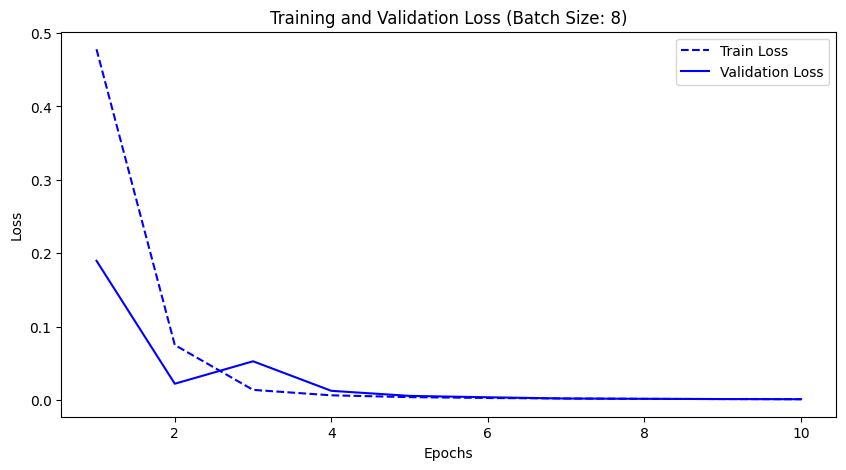

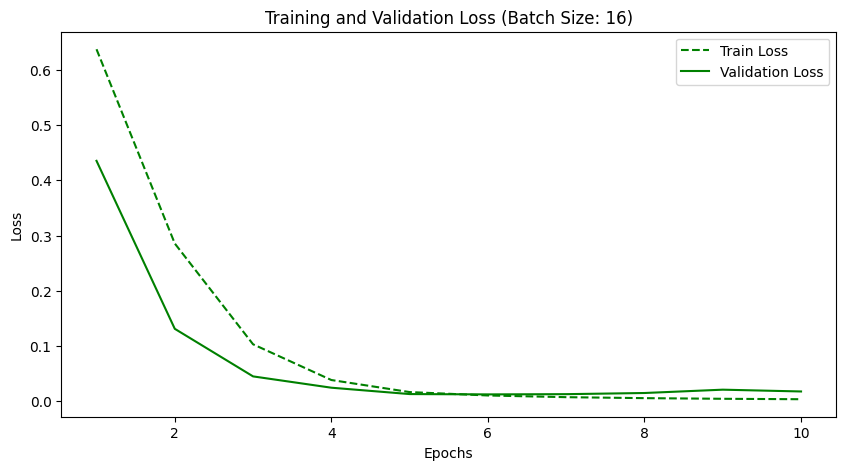

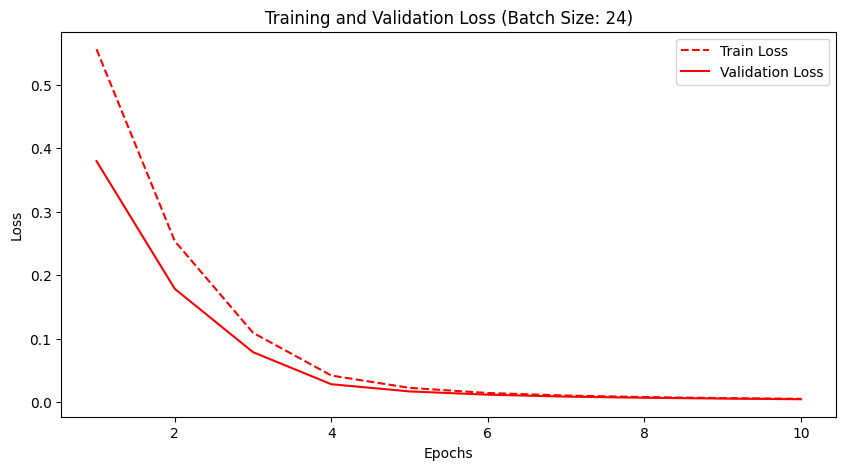

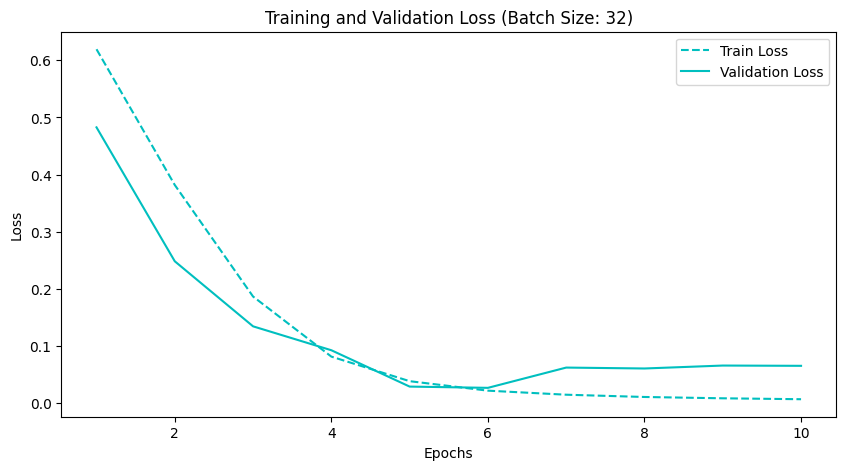

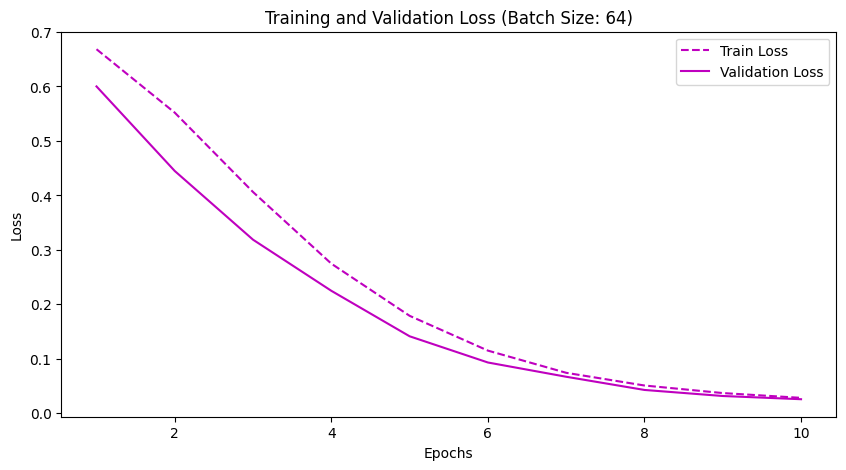

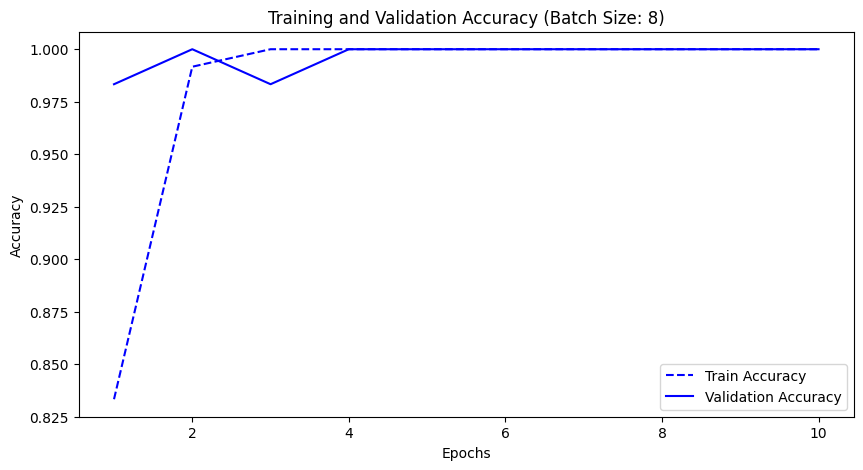

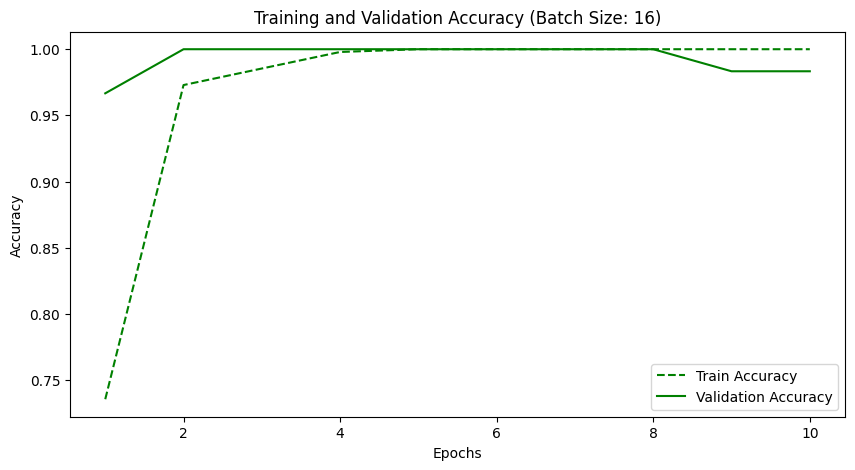

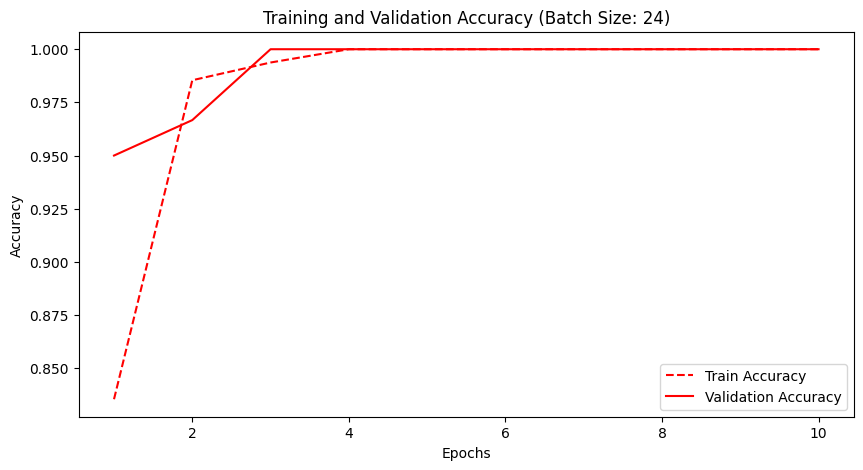

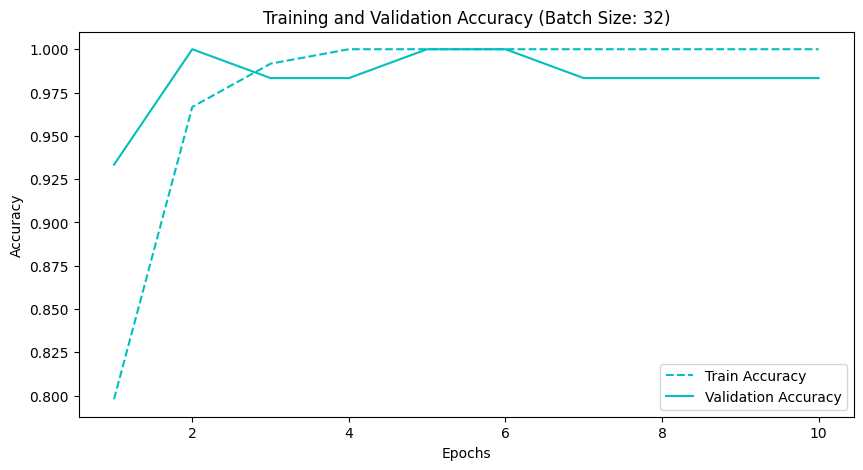

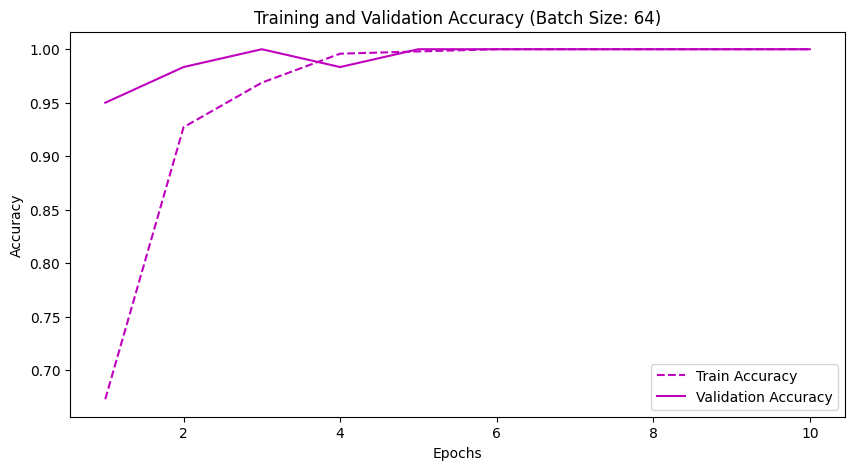

In [ ]:
plot_results(batch_size_data)

# Evaluate model performance on unseen test data

In [ ]:
def test_data_evaluation(texts, test_encodings, test_labels, model):
    # Create dataloader for test data
    test_dataloader = create_dataloader(test_encodings, test_labels, batch_size=64, randomize=False)

    # Evaluate model on test data
    test_loss, test_acc = evaluate_model(model, test_dataloader, device)
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_acc}')

    # Switch model to evaluation mode
    model.eval()

    # Initialize lists for predictions and true labels
    predictions = []
    true_labels = []

    # Iterate through batches in test dataloader
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        # Disable gradient calculation
        with torch.no_grad():
            logits = model(input_ids, attention_mask)
            preds = torch.sigmoid(logits).round()

            # Extend lists with predictions and true labels
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Convert numpy arrays to lists
    predictions = [pred.item() for pred in predictions]

    # Create DataFrame to store results
    final_df = pd.DataFrame({
        'context': texts,
        'true_label': true_labels,
        'model_predictions': predictions
    })

    # Calculate accuracy
    accuracy = accuracy_score(final_df['true_label'], final_df['model_predictions'])
    print("Accuracy:", accuracy, '\n')

    # Display confusion matrix
    matrix = confusion_matrix(true_labels, predictions)
    print("Confusion Matrix:")
    print(matrix, '\n')

    # Find misclassifications
    misclass_df = final_df[final_df['true_label'] != final_df['model_predictions']]
    print("List of Misclassifications:")

    return misclass_df


In [ ]:
best_model_name

'screen_bert_2fc_v0_1_8_.pth'

In [ ]:
test_data_evaluation(test_texts, test_encodings, test_labels, best_model)

Test Loss: 0.12122342735528946
Test Accuracy: 0.9833333333333333
Accuracy: 0.9833333333333333 

Confusion Matrix:
[[30  0]
 [ 1 29]] 

List of Misclassifications:


,context,true_label,model_predictions
173,Agile practices are something I'm deeply famil...,1,0.0


In [ ]:
test_data_evaluation(val_texts, val_encodings, val_labels, best_model)

Test Loss: 0.000972175388596952
Test Accuracy: 1.0
Accuracy: 1.0 

Confusion Matrix:
[[30  0]
 [ 0 30]] 

List of Misclassifications:


,context,true_label,model_predictions


In [ ]:
test_data_evaluation(train_texts, train_encodings, train_labels, best_model)

Test Loss: 0.0007634387366124429
Test Accuracy: 1.0
Accuracy: 1.0 

Confusion Matrix:
[[239   0]
 [  0 241]] 

List of Misclassifications:


,context,true_label,model_predictions


#### Export The Fine-Tuned Model

In [ ]:
# # Uncomment if export is needed
# torch.save(model.state_dict(), fine_tuned_model_name)
# tokenizer.save_pretrained(tokenizer_directory_name)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Testing model import for pipeline

### Knowledge Assesment

In [ ]:
import spacy
from transformers import pipeline

In [ ]:
#Function to load skill extraction pipeline
def load_skill_extraction_pipeline():
    """
    Load a BERT-based Named Entity Recognition (NER) model for skills extraction.

    Returns:
        pipeline: A pipeline object for skill extraction using the loaded NER model.
                  Returns None if an error occurs during loading.
    """
    try:
        model_name = "GalalEwida/LLM-BERT-Model-Based-Skills-Extraction-from-jobdescription"
        ner = pipeline(task="ner", model=model_name)
        print("NER for skills extraction loaded loaded successflly.")
        return ner
    except Exception as e:
        raise Exception("Error occurred while loading the skill extraction pipeline:", e)
        return None

In [ ]:
# Function to extract skills from text using the NER model
def extract_skills(input, ner):
    """
    Extract skills from the given input text using the provided NER model.

    Args:
        input (str): The input text from which skills are to be extracted.
        ner (pipeline): The NER model pipeline for skill extraction.

    Returns:
        list: A list of extracted skills. Returns None if an error occurs during extraction.
    """
    try:
        predictions = ner(input)
        print("Skills extracted successfully.")
        return predictions
    except Exception as e:
        raise Exception("Error occurred while extracting skills:", e)
        return None

In [ ]:
#function to turn the raw output to a list of skills
def skill_preprocessing(input):
    """
    Preprocess the output of the skill extraction model.

    Args:
        input (list): A list of dictionaries representing the output of the skill extraction model.
                      Each dictionary contains 'word' and 'entity' keys representing a predicted token and its entity label.

    Returns:
        list: A list of unique skills extracted from the input.
              Returns None if an error occurs during preprocessing.
    """
    try:
        skill_set = set()
        current_skill = None
        for element in input:
            word = element.get('word')
            entity_label = element.get('entity')
            if word is None or entity_label is None:
                continue
            if entity_label.startswith('B'):
                if current_skill:
                    skill_set.add(current_skill)
                current_skill = word
            elif entity_label.startswith('I'):
                if current_skill:
                    if '##' in word:
                        word = word.replace('##', '')
                        current_skill += word
                    else:
                        current_skill += ' ' + word
        if current_skill:
            skill_set.add(current_skill)
        print("Skill set extraced successfully.")
        return list(skill_set)
    except Exception as e:
        print("Error occurred during skill preprocessing:", e)
        return None

In [ ]:
# Extract entities related to the topic
def sentence_extraction(doc, skill_set):
    doc = nlp(doc)
    topic_sentences = {}
    for skill in skill_set:
      topic_sentences[skill] = [sent.text for sent in doc.sents if skill in sent.text.lower()]
    print("Entities related to skills extracted successfully.")
    return topic_sentences

In [ ]:
def classify_this(text):
    inputs = tokenizer.encode_plus(text, add_special_tokens=True, return_tensors='pt')
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    with torch.no_grad():
        raw_scores = model(input_ids, attention_mask)
        print(f'Raw scores for both classes (positive and negative) = {raw_scores}')

    probabilities = torch.sigmoid(raw_scores).item()
    # logger.info(f'probabilities: {probabilities}')

    # here we could introduce multi-classification
    prediction = 1 if probabilities > 0.5 else 0
    # logger.info(f'prediction: {prediction}')

    return prediction, probabilities

In [ ]:
def run_pipeline(text):

    predictions = extract_skills(text, ner)
    skill_list = skill_preprocessing(predictions)

    topic_sentences = sentence_extraction(text, skill_list)

    print("Classifying ...")

    for skill, sentences in topic_sentences.items():
        for sentence in sentences:
            prediction, probability = classify_this(sentence)
            print('Skill:', skill)
            print('Sentence:', sentence)
            print('Prediction:', prediction)
            print('Probability:', probability, '\n')

In [ ]:
# Initialize global variables
ner = load_skill_extraction_pipeline()
nlp = spacy.load("en_core_web_sm")
model = best_model
tokenizer = pretrained_tokenizer

NER for skills extraction loaded loaded successflly.


In [ ]:
text1 = '''I've heard the term machine learning before, but I must admit that I don't have extensive knowledge about them.'''

In [ ]:
run_pipeline(text1)

Skills extracted successfully.
Skill set extraced successfully.
Entities related to skills extracted successfully.
Classifying ...
Raw scores for both classes (positive and negative) = tensor([[-6.4422]], device='cuda:0')
Skill: machine learning
Sentence: I've heard the term machine learning before, but I must admit that I don't have extensive knowledge about them.
Prediction: 0
Probability: 0.0015903905732557178 



In [ ]:
text3 = "For example, in a project I worked on during my studies, I used a machine learning to classify different types of fruits from images."

In [ ]:
run_pipeline(text3)

Skills extracted successfully.
Skill set extraced successfully.
Entities related to skills extracted successfully.
Classifying ...
Raw scores for both classes (positive and negative) = tensor([[6.7465]], device='cuda:0')
Skill: machine learning
Sentence: For example, in a project I worked on during my studies, I used a machine learning to classify different types of fruits from images.
Prediction: 1
Probability: 0.9988264441490173 



In [ ]:
text2 = '''i know computer science because i contributed to a computer science project'''
run_pipeline(text2)

Skills extracted successfully.
Skill set extraced successfully.
Entities related to skills extracted successfully.
Classifying ...
Raw scores for both classes (positive and negative) = tensor([[6.5549]], device='cuda:0')
Skill: computer science
Sentence: i know computer science because i contributed to a computer science project
Prediction: 1
Probability: 0.9985789060592651 



In [ ]:
text2 = '''neural networks is something i am familiar with, since i worked with it in the past'''
run_pipeline(text2)

Skills extracted successfully.
Skill set extraced successfully.
Entities related to skills extracted successfully.
Classifying ...
Raw scores for both classes (positive and negative) = tensor([[-6.3850]], device='cuda:0')
Skill: neural networks
Sentence: neural networks is something i am familiar with, since i worked with it in the past
Prediction: 0
Probability: 0.0016837703296914697 



In [ ]:
text2 = '''i know computer science'''
run_pipeline(text2)

Skills extracted successfully.
Skill set extraced successfully.
Entities related to skills extracted successfully.
Classifying ...
Raw scores for both classes (positive and negative) = tensor([[6.5411]], device='cuda:0')
Skill: computer science
Sentence: i know computer science
Prediction: 1
Probability: 0.9985591769218445 

